## Overview

The aim of this project is to build a deep neural network to identify the breed of a dog from an image.

## Approach

* This project trains several convolutional neural networks to build a dog breed classifier.
* We start with training a CNN from scratch without any image augmentation, and then add in image augmentation. This should make for a better model, as augmentation corrects for position and orientation of features in the training images.
* Training from scratch is time and resource intensive, so instead of further fine-tuning we can use transfer learning to use parts of pre-trained CNNs and fit them on our data to build a model. This should give better results with shorter training times
* A validation subset is used as a means to adjust for overfitting in all the models. 

## Data input 

- Three folders of dog images for train,validation & test datasets.
- The images have been provided by Udacity as part of their Data Scientist nanodegree.
- The images are in the RGB colorspace.

## Sucess Metrics

* Accuracy - the ratio of total correct predictions to the total samples in the test dataset. This will help give an idea of overall accuracy of each model
* Precsion - To identify the proportion of positive identifications that were actually correct.
* Recall - To identify the proportion of actual positives that were identified correctly.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import time


def load_dataset(path):
    """
    Function to load train, test, and validation datasets
    
    Parameters:
    path (str) : directory path to images that are to be loaded
    
    Returns:
    dog_files  : Array of individual filenames for all images in the path
    dog_targets : Array of one hot encoded breed of each dog with an image in the path
    """
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Data preprocessing steps
* To be able to work with these files we load all these images and convert them into 4D tensors, that will represent all smaple images in three color channels.
* The images are sized to 244*244 pixels
* Later in the project, further preprocessing is done using a generator function. This is to save on memory use, by loading and processing images in small batches, just in time for training.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """
    Function to load an image and convert to a 4D tensor
    
    Parameters:
    img_path (str) : file path to image
    
    Returns:
    numpy array  : 4D tensor with pixel values of the image in all three channels
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Function to build a 4D tensor of all images in the paths specified
    
    Parameters:
    img_paths : array fo file paths to all images to be loaded
    Returns:
    numpy array  : 4D tensor of all images located in the paths provided
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile     
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('ubyte')
valid_tensors = paths_to_tensor(valid_files).astype('ubyte')
test_tensors = paths_to_tensor(test_files).astype('ubyte')

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:04<00:00, 198.75it/s]


## Data Exploration and Visualization

#### Let's plot a subset of our training images to see the structure of our data

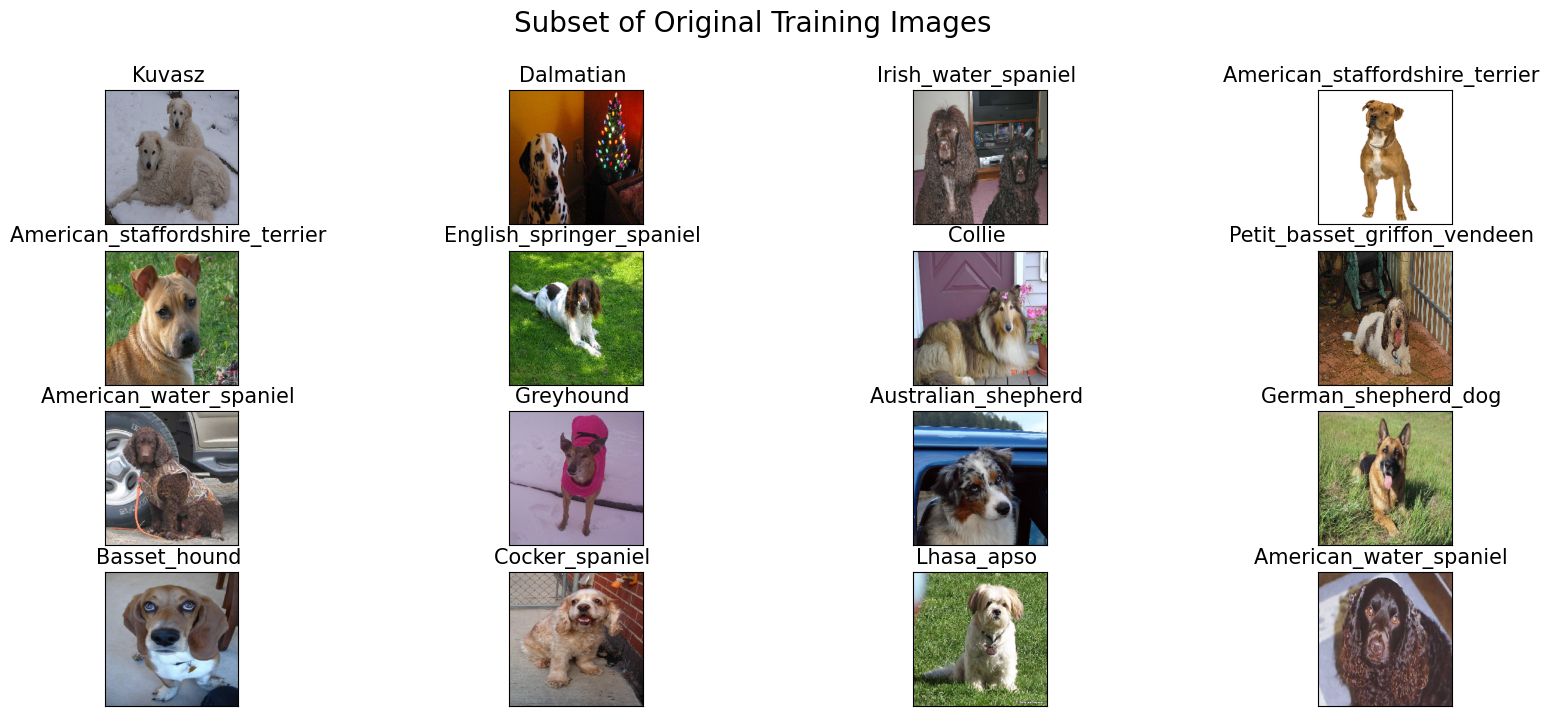

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#Subset of training data
train_tensors_subset = train_tensors[:16].astype('float32')/255

fig = plt.figure(figsize=(20,8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(train_tensors_subset[i]))
    true_idx = np.argmax(train_targets[i])
    ax.set_title("{} ".format(dog_names[true_idx]),color=("black"),fontsize=15)
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

#### Image preprocessing steps like normalizing, centering and standardizing pixel values have been shown to improve accuracy in many groundbreaking CNNs. So we will look at the distribution of pixel values in the training images.

In [6]:
#Summary staistics of pixel values in training images
print("Minimum pixel value : ",np.min(train_tensors))
print("Maximum pixel value : ",np.max(train_tensors))
print("Average pixel value : ",np.mean(train_tensors))
train_tensors_int = np.copy(train_tensors).astype('ubyte')
print("Standard deviation of pixel value : ",np.std(train_tensors_int))
del train_tensors_int

Minimum pixel value :  0
Maximum pixel value :  255
Average pixel value :  114.81187083641231
Standard deviation of pixel value :  68.23901212342862


#### As the range of pixel values is 255 as seen above, we will need to rescale the images by 255 to normalize the images.

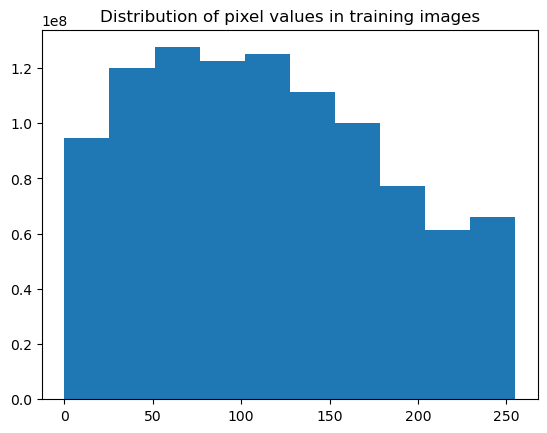

In [7]:
#Plotting a histogram of all pixel values in all images in the input dataset
train_tensors_flattened = np.copy(train_tensors).flatten()
plt.hist(train_tensors_flattened)
plt.title('Distribution of pixel values in training images')
plt.show()
del train_tensors_flattened

### 1. CNN from scratch, without Image Augmentation

#### As a baseline, let's build a CNN without any image augmentation. 

#### As passing entire training set during model fitting would be very memeory intensive, we are creating a generator that will feed training images in batches, in real time.

#### 1.1 Create an Image Generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Reduce this to reduce memory requirements, but will increase training time
batch_size = 32

# create and configure image generators for train and validation data 
datagen_train = ImageDataGenerator(rescale=1.0/255.0,# Rescaling to normalize images  
                            dtype='float16')

datagen_valid = ImageDataGenerator(rescale=1.0/255.0,# Rescaling to normalize images  
                            dtype='float16')


#Create iterators to be used in the model fit step
train_iterator = datagen_train.flow(train_tensors, train_targets, batch_size=batch_size)
valid_iterator = datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size)

#### 1.2 Model Architecture


In [5]:
import gc
gc.collect()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

CNN_without_augmentation = Sequential()
CNN_without_augmentation.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
CNN_without_augmentation.add(MaxPooling2D(pool_size=2))
CNN_without_augmentation.add(GlobalAveragePooling2D())
CNN_without_augmentation.add(Dropout(0.4))
CNN_without_augmentation.add(Dense(133, activation='softmax'))

CNN_without_augmentation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

#### 1.3 Compile the Model

In [6]:
CNN_without_augmentation.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

#### 1.4 Train the Model

In [7]:
from keras.callbacks import ModelCheckpoint   
from keras.preprocessing.image import Iterator

# train the model
epochs = 40

checkpointer = ModelCheckpoint(filepath='Saved models/CNN_without_augmentation.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
start_time = time.time()

CNN_without_augmentation.fit(train_iterator,
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1,  callbacks=[checkpointer],
                    validation_data = valid_iterator,
                    validation_steps=valid_tensors.shape[0] // batch_size                  
                   )

CNN_without_augmentation_training_time = time.time()-start_time
print("Training time:", CNN_without_augmentation_training_time)

Epoch 1/40
208/208 [==============================] - 34s 44ms/step - loss: 4.8847 - accuracy: 0.0077 - val_loss: 4.8701 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 4.87013, saving model to Saved models\CNN_without_augmentation.weights.best.hdf5
Epoch 2/40
208/208 [==============================] - 8s 40ms/step - loss: 4.8737 - accuracy: 0.0093 - val_loss: 4.8704 - val_accuracy: 0.0108

Epoch 00002: val_loss did not improve from 4.87013
Epoch 3/40
208/208 [==============================] - 8s 40ms/step - loss: 4.8657 - accuracy: 0.0114 - val_loss: 4.8469 - val_accuracy: 0.0108

Epoch 00003: val_loss improved from 4.87013 to 4.84694, saving model to Saved models\CNN_without_augmentation.weights.best.hdf5
Epoch 4/40
208/208 [==============================] - 8s 40ms/step - loss: 4.8231 - accuracy: 0.0152 - val_loss: 4.7413 - val_accuracy: 0.0216

Epoch 00004: val_loss improved from 4.84694 to 4.74134, saving model to Saved models\CNN_without_augmentation.weights.be

In [8]:
def oneHot_to_categories(oneHotVector,categories) :
    """
    Function to transform one hot encoded target tensors into the categories each of them represent
    
    Parameters:
    oneHotVector : 2D tensor of all target  values
    categories : List of all possible categories in the calssification space
    
    Returns:
    numpy array  : Array of category for each target in the input target value tensor
    """
    #Get index of activated element for each oneHotvector in the input
    cat_index_array = np.argmax(oneHotVector,axis=1)
    
    #Lookup from index to categories list to get actual category name
    return np.array([categories[id] for id in np.argmax(oneHotVector,axis=1)])

import pandas as pd
from sklearn.metrics import classification_report

def success_metrics(model,weights_path,test_iterator,targets_oneHot,class_names=dog_names):
    """
    Function to caculate accuracy, pecision & recall for a given model for given test input and outputs
    
    Parameters:
    model : Model tobe evaluated 
    weights_path : Path to best weights to be loaded into the model
    test_iterator : Iterator or 4D tensor of all test images
    targets_oneHot : Actual targets one hot encoded
    class_names : List of all possible categories in the calssification space
    
    Returns:
    Pandas DataFrame  : Dataframe containing accuracy, pecision & recall
    """
    #Load the Model with the Best Validation Loss 
    model.load_weights(weights_path)
    
    #Predictions for given test inputs
    predictions_oneHot = model.predict(test_iterator)
    predictions = oneHot_to_categories(predictions_oneHot,class_names)
    
    #Transforming one hot encoded targets tensors into categorical values
    targets = oneHot_to_categories(targets_oneHot,class_names)
    class_report = classification_report(
                        targets, 
                        predictions, 
                        labels=dog_names,
                        output_dict = True,
                        zero_division = 0.0)
    #Delete to free space
    del predictions_oneHot
    del predictions
    del targets
    
    return pd.DataFrame([class_report['accuracy'],
              class_report['macro avg']['precision'],
              class_report['macro avg']['recall']],
             index=['Accuracy','Precision','Recall']).T

#### 1.5 Test the Model with the best validation loss

In [9]:
#Normalizing the test images
test_tensors_normalized = test_tensors.astype('float16')/255
CNN_without_augmentation_metrics = success_metrics(
                                  model = CNN_without_augmentation,
                                  weights_path = 'Saved models/CNN_without_augmentation.weights.best.hdf5',
                                  test_iterator = test_tensors_normalized,
                                  targets_oneHot = test_targets)
del test_tensors_normalized
CNN_without_augmentation_metrics.index=['CNN_without_augmentation']
CNN_without_augmentation_metrics['Training time (min)']=[CNN_without_augmentation_training_time/60]
CNN_without_augmentation_metrics

,Accuracy,Precision,Recall,Training time (min)
CNN_without_augmentation,0.238038,0.254355,0.228303,6.480181


#### As we can see this model can predict much better than random chance, in a reasonable amount of training time. But we can do better by augmenting our training data.

### 2. CNN from scratch, with Image Augmentation

#### Now, let's build a CNN with training images augmented with position and orientation changes

#### 2.1 Create and Configure Augmented Image Generator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

#Lowering this will ease memory requirements but increase train time
batch_size=32

# create and configure augmented image generators for training and validation data
CNN_with_augmentation_datagen_train = ImageDataGenerator(  
    rescale=1.0/255.0,# Rescaling to normalize images 
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally 
    dtype='float16')

CNN_with_augmentation_datagen_valid = ImageDataGenerator(  
    rescale=1.0/255.0,# Rescaling to normalize images 
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally 
    dtype='float16')

# fit augmented image generators on training and validation data. 
# This calculates featurewide statistics needed to perform augmentation
CNN_with_augmentation_datagen_train.fit(train_tensors)
CNN_with_augmentation_datagen_valid.fit(valid_tensors)

#Create iterators to be used in the model fit step.
CNN_with_augmentation_train_iterator = CNN_with_augmentation_datagen_train.flow(train_tensors, train_targets, batch_size=batch_size)
CNN_with_augmentation_valid_iterator = CNN_with_augmentation_datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size)

#### 2.2 Visualize Original and Augmented Images

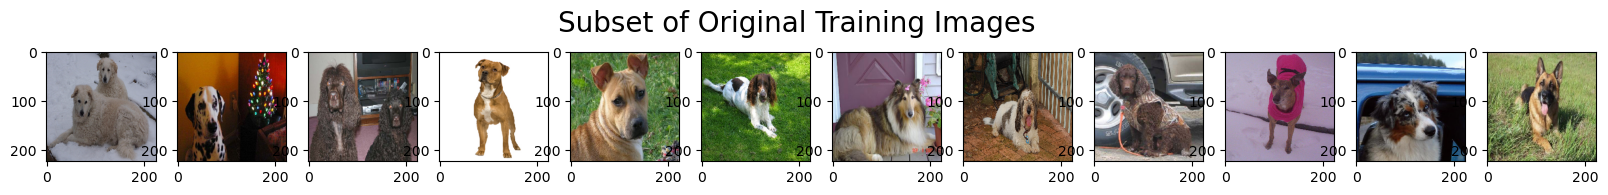

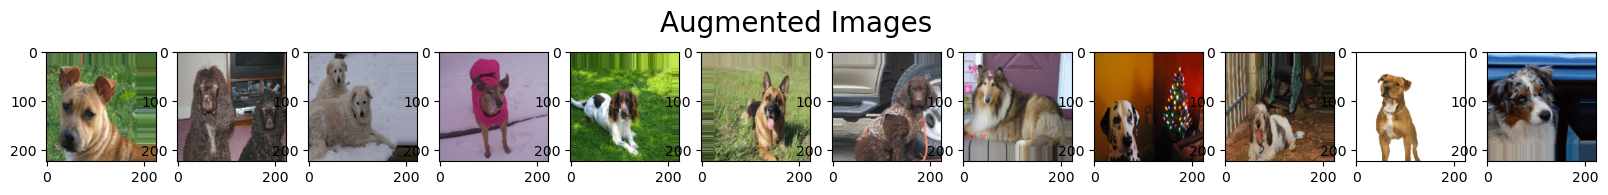

In [18]:
import matplotlib.pyplot as plt

# take subset of training data
train_tensors_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(train_tensors_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(train_tensors_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for train_tensors_batch in CNN_with_augmentation_datagen_train.flow(train_tensors_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(train_tensors_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

#### 2.3 Model Architecture 

In [11]:
import gc
gc.collect()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

CNN_with_augmentation = Sequential()
CNN_with_augmentation.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
CNN_with_augmentation.add(MaxPooling2D(pool_size=2))
CNN_with_augmentation.add(GlobalAveragePooling2D())
CNN_with_augmentation.add(Dropout(0.4))
CNN_with_augmentation.add(Dense(133, activation='softmax'))

CNN_with_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)       

#### 2.4 Compile the model

In [12]:
CNN_with_augmentation.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

#### 2.5 Train the Model 

In [13]:
from keras.callbacks import ModelCheckpoint   

# train the model
epochs = 40

# train the model
checkpointer = ModelCheckpoint(filepath='Saved models/CNN_with_augmentation.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

start_time = time.time()

CNN_with_augmentation.fit(CNN_with_augmentation_train_iterator,
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1,  callbacks=[checkpointer],
                    validation_data = CNN_with_augmentation_valid_iterator,
                    validation_steps=valid_tensors.shape[0] // batch_size                  
                   )

CNN_with_augmentation_training_time = time.time()-start_time
print("Training time:", CNN_with_augmentation_training_time)

Epoch 1/40
208/208 [==============================] - 69s 323ms/step - loss: 4.8841 - accuracy: 0.0086 - val_loss: 4.8757 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 4.87567, saving model to Saved models\CNN_with_augmentation.weights.best.hdf5
Epoch 2/40
208/208 [==============================] - 64s 308ms/step - loss: 4.8685 - accuracy: 0.0110 - val_loss: 4.8627 - val_accuracy: 0.0108

Epoch 00002: val_loss improved from 4.87567 to 4.86271, saving model to Saved models\CNN_with_augmentation.weights.best.hdf5
Epoch 3/40
208/208 [==============================] - 65s 312ms/step - loss: 4.8385 - accuracy: 0.0108 - val_loss: 4.8024 - val_accuracy: 0.0204

Epoch 00003: val_loss improved from 4.86271 to 4.80236, saving model to Saved models\CNN_with_augmentation.weights.best.hdf5
Epoch 4/40
208/208 [==============================] - 65s 311ms/step - loss: 4.7655 - accuracy: 0.0220 - val_loss: 4.7016 - val_accuracy: 0.0276

Epoch 00004: val_loss improved from 4.80236 t

#### 2.6 Test the Model with the best validation loss

In [14]:
test_tensors_normalized = test_tensors.astype('float16')/255
CNN_with_augmentation_metrics = success_metrics(
                                  model = CNN_with_augmentation,
                                  weights_path = 'Saved models/CNN_with_augmentation.weights.best.hdf5',
                                  test_iterator = test_tensors_normalized,
                                  targets_oneHot = test_targets)
del test_tensors_normalized
CNN_with_augmentation_metrics.index=['CNN_with_augmentation']
CNN_with_augmentation_metrics['Training time (min)']=[CNN_with_augmentation_training_time/60]
CNN_with_augmentation_metrics

,Accuracy,Precision,Recall,Training time (min)
CNN_with_augmentation,0.336124,0.316325,0.315524,43.698438


### Metrics for CNNs trained form scratch

In [15]:
CNN_trained_from_scratch_metrics = pd.concat([CNN_without_augmentation_metrics, CNN_with_augmentation_metrics])
CNN_trained_from_scratch_metrics

,Accuracy,Precision,Recall,Training time (min)
CNN_without_augmentation,0.238038,0.254355,0.228303,6.480181
CNN_with_augmentation,0.336124,0.316325,0.315524,43.698438


#### It looks like augmenting training images increases accuracy of the model significantly, but it also significantly increases training time. We can now further fine-tune this model, but the significant training time and memory use will make this process slow. This is where transfer learning can help.

### 3. Models using Transfer Learning

- Instead of training an entire model from scratch, we can use pre-trained image classification models to speed up training time. The models we will use are `VGG19`, `Resnet50`, `InceptionV3` and `Xception`.
- Specifically, we will be stripping the final flat layers in these models and freeze the weights in the rest of the layers and add our own flat layers and train them.
- Since these models are huge and calculating outputs of the frozen layers is very memory intensive, I will be using pre-computed values for this. They can be downloaded from here : 
    - [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
    - [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
    - [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
    - [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features
- Download all four of the above linked files and save them to 'bottleneck_features/'

**The credit for the pre-computed Bottleneck features goes to Udacity. These were provided as part of the Data Scientist Nanodegree.**

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint   


def transfer_learning_model_train(pre_trained_model,bottleneck_features_path,weights_save_path):
    """
    Function to train a model using transfer learning 
    
    Parameters:
    pre_trained_model : Pre trained model to be used as the base
    bottleneck_features_path : path to the pre-computed bottleneck features
    weights_save_path : path to save the weights with best validation loss
    
    Returns:
    model : Final trained model
    test_features : Bottleneck features for the test data
    training_time : Time taken to train the model
    """
    
    pre_trained_model_end_stripped = pre_trained_model(include_top=False)
    print('Summary of the Pre-trained model with the flattenned layers stripped')
    pre_trained_model_end_stripped.summary()
    
    bottleneck_features = np.load(bottleneck_features_path)
    train_features = bottleneck_features['train'].astype('float16')
    valid_features = bottleneck_features['valid'].astype('float16')
    test_features = bottleneck_features['test'].astype('float16')
    
    # create train image generator
    datagen_train = ImageDataGenerator() 
    
    # create validation image generator
    datagen_valid = ImageDataGenerator()
    
    #Define model architecture
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
    model.add(Dense(133, activation='softmax'))
    print('Summary of model to be trained')
    model.summary()
    
    #Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath=weights_save_path, 
                               verbose=1, save_best_only=True)

    #Train the model
    batch_size = 32
    epochs = 25
    
    start_time = time.time()
    
    model.fit(datagen_train.flow(train_features, train_targets, batch_size=batch_size),
                        steps_per_epoch=train_features.shape[0] // batch_size,
                        epochs=epochs, verbose=1,  callbacks=[checkpointer],
                        validation_data = datagen_valid.flow(valid_features, valid_targets, batch_size=batch_size),
                        validation_steps=valid_features.shape[0] // batch_size                  
                       )
    
    training_time = time.time()-start_time
    print("Training time:", training_time)    
    
    del bottleneck_features
    del train_features
    del valid_features
    return model,test_features,training_time

#### 3.1 Transfer learning using VGG19

##### 3.1.1 Define and train the model

In [4]:
import gc
gc.collect()

VGG16_model,test_VGG16_input,VGG16_training_time = transfer_learning_model_train(
                              pre_trained_model = VGG16,
                              bottleneck_features_path = 'bottleneck_features/DogVGG16Data.npz',
                              weights_save_path = 'Saved models/transferLweights.best.VGG16.hdf5')

Summary of the Pre-trained model with the flattenned layers stripped
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
__________________________________________________________

##### 3.1.2 Test the model with the best validation loss

In [5]:
VGG16_model_metrics = success_metrics(
                                  model = VGG16_model,
                                  weights_path = 'Saved models/transferLweights.best.VGG16.hdf5',
                                  test_iterator = test_VGG16_input,
                                  targets_oneHot = test_targets)
VGG16_model_metrics.index=['Transfer learning using VGG16']
VGG16_model_metrics['Training time (min)']=[VGG16_training_time/60]
VGG16_model_metrics

,Accuracy,Precision,Recall,Training time (min)
Transfer learning using VGG16,0.735646,0.745898,0.723132,0.449867


#### 3.2 Transfer learning using ResNet50

##### 3.2.1 Define and train the model

In [6]:
from keras.applications.resnet import ResNet50
import gc
gc.collect()

ResNet50_model,test_ResNet50_input,ResNet50_training_time = transfer_learning_model_train(
                              pre_trained_model = ResNet50,
                              bottleneck_features_path = 'bottleneck_features/DogResnet50Data.npz',
                              weights_save_path = 'Saved models/transferLweights.best.ResNet50.hdf5')

Summary of the Pre-trained model with the flattenned layers stripped
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________

##### 3.2.2 Test the model with the best validation loss

In [7]:
ResNet50_model_metrics = success_metrics(
                                  model = ResNet50_model,
                                  weights_path = 'Saved models/transferLweights.best.ResNet50.hdf5',
                                  test_iterator = test_ResNet50_input,
                                  targets_oneHot = test_targets)
ResNet50_model_metrics.index=['Transfer learning using ResNet50']
ResNet50_model_metrics['Training time (min)']=[ResNet50_training_time/60]
ResNet50_model_metrics

,Accuracy,Precision,Recall,Training time (min)
Transfer learning using ResNet50,0.82177,0.833805,0.806475,0.199225


### 3.3 Transfer learning using InceptionV3

##### 3.3.1 Define and train the model

In [8]:
from keras.applications.inception_v3 import InceptionV3
import gc
gc.collect()

Inception_model,test_Inception_input,Inception_training_time = transfer_learning_model_train(
                              pre_trained_model = InceptionV3,
                              bottleneck_features_path = 'bottleneck_features/DogInceptionV3Data.npz',
                              weights_save_path = 'Saved models/transferLweights.best.Inception.hdf5')

Summary of the Pre-trained model with the flattenned layers stripped
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________

##### 3.3.2 Test the model with the best validation loss

In [9]:
Inception_model_metrics = success_metrics(
                                  model = Inception_model,
                                  weights_path = 'Saved models/transferLweights.best.Inception.hdf5',
                                  test_iterator = test_Inception_input,
                                  targets_oneHot = test_targets)
Inception_model_metrics.index=['Transfer learning using Inception']
Inception_model_metrics['Training time (min)']=[Inception_training_time/60]
Inception_model_metrics

,Accuracy,Precision,Recall,Training time (min)
Transfer learning using Inception,0.800239,0.835057,0.784909,0.484276


#### 3.4 Transfer learning using Xception

##### 3.4.1 Define and train the model

In [10]:
from keras.applications.xception import Xception
import gc
gc.collect()

Xception_model,test_Xception_input,Xception_training_time = transfer_learning_model_train(
                              pre_trained_model = Xception,
                              bottleneck_features_path = 'bottleneck_features/DogXceptionData.npz',
                              weights_save_path = 'Saved models/transferLweights.best.Xception.hdf5')

Summary of the Pre-trained model with the flattenned layers stripped
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________

##### 3.1.2 Test the model with the best validation loss

In [11]:
Xception_model_metrics = success_metrics(
                                  model = Xception_model,
                                  weights_path = 'Saved models/transferLweights.best.Xception.hdf5',
                                  test_iterator = test_Xception_input,
                                  targets_oneHot = test_targets)
Xception_model_metrics.index=['Transfer learning using Xception']
Xception_model_metrics['Training time (min)']=[Xception_training_time/60]
Xception_model_metrics

,Accuracy,Precision,Recall,Training time (min)
Transfer learning using Xception,0.845694,0.86262,0.831633,1.024893


### Metrics for CNNs trained using transfer learning

In [12]:
CNN_transfer_trained_metrics = pd.concat([VGG16_model_metrics,ResNet50_model_metrics,Inception_model_metrics, Xception_model_metrics])
CNN_transfer_trained_metrics

,Accuracy,Precision,Recall,Training time (min)
Transfer learning using VGG16,0.735646,0.745898,0.723132,0.449867
Transfer learning using ResNet50,0.821770,0.833805,0.806475,0.199225
Transfer learning using Inception,0.800239,0.835057,0.784909,0.484276
Transfer learning using Xception,0.845694,0.862620,0.831633,1.024893


- Transfer learning significantly improves accuracy and reduces train times. 
- Using the Xception model gives the highest accuracy.
- Lets visualize some predictions using the Xception model.

### Visualizing Some Predictions

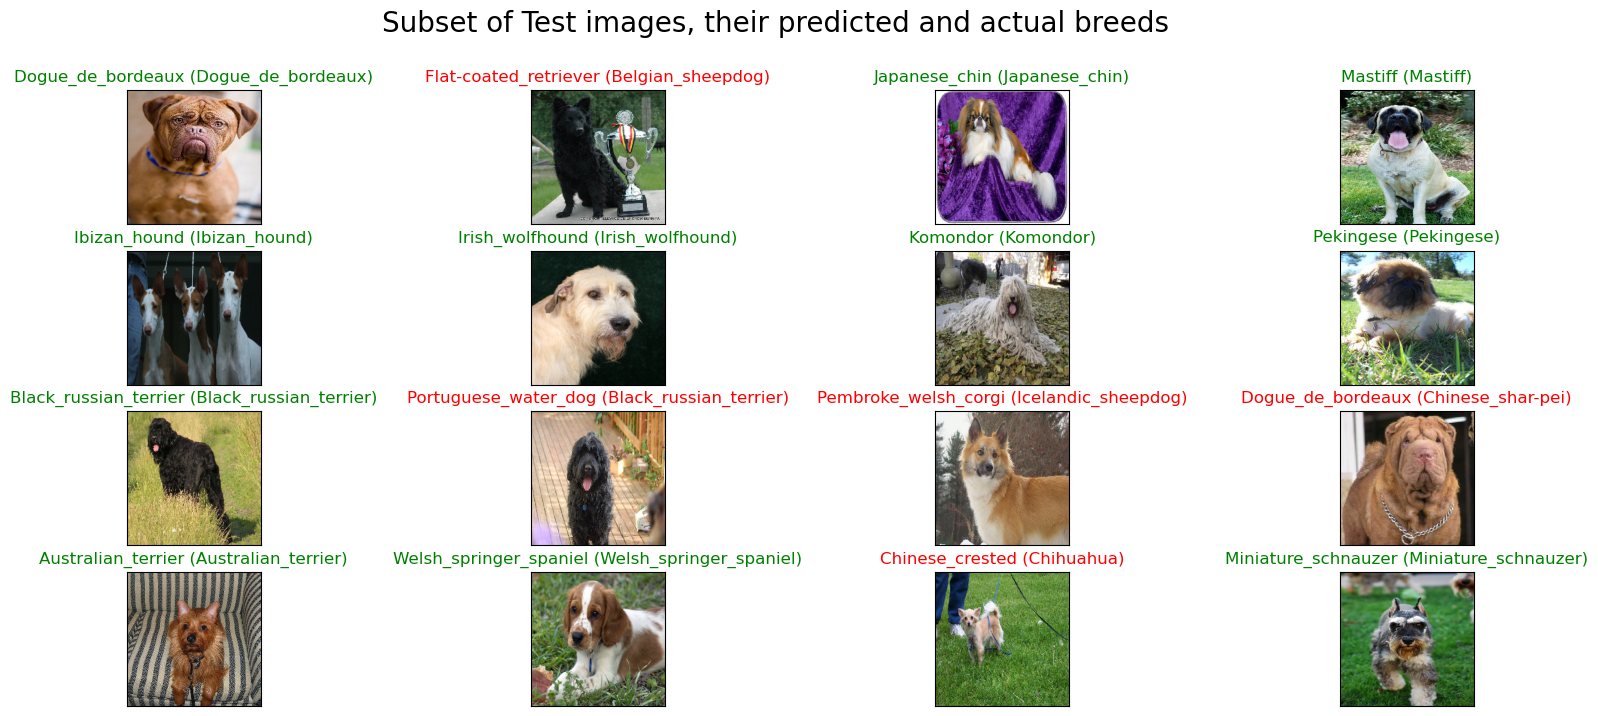

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

test_tensors_normalized = test_tensors.astype('float32')/255
Xception_model_test_preds = Xception_model.predict(test_Xception_input)
# test_preds_dog_names = oneHot_to_categories(test_preds_oneHot,dog_names)
# test_targets_dog_names = oneHot_to_categories(test_targets,dog_names)

# plot a random sample of test images, their predicted labels, and ground truth for the model with highest accuracy
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(test_tensors_normalized.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors_normalized[idx]))
    pred_idx = np.argmax(Xception_model_test_preds[idx])
    true_idx = np.argmax(test_targets[idx])
    ax.set_title("{} ({})".format(dog_names[pred_idx], dog_names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
fig.suptitle('Subset of Test images, their predicted and actual breeds', fontsize=20)
plt.show()

### Final Thoughts

#### It is clear that transfer learning yields the best results for the shortest training time. Also Image augmentation increases accuracy but also takes much longer to train.

### Further steps

This project can be further improved by :
- The pre-trained models were trained on a variety of images. Many of them are not dogs. This might cause the layers at the end of the model to identify features that might be irrelevant to images of dogs. We can strip further layers at the end of these models and add our own convilutional layers and re-train the models.
- Given time and a larger GPU, the baseline model can be further enhanced.